# Drift MPC

In [1]:
from mc_utils_LT import *
from scipy.linalg import block_diag

ACADOS_SOURCE_DIR: /Users/marcocortese/repos/acados


In [ ]:
# casadi/acados model
import casadi as ca
from casadi import SX, sqrt, atan, tan, sin, cos, tanh, atan2, fabs, vertcat, if_else, sign
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver, AcadosSim, AcadosSimSolver
# suppress warnings acados
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='acados_template')

def STM_model_dt_inputs():
    # variables
    v = SX.sym('v') # velocity
    # v̇ = SX.sym('v̇') # velocity dot
    beta = SX.sym('beta') # sideslip angle
    # β̇ = SX.sym('β̇') # sideslip angle dot
    r = SX.sym('r') # yaw rate
    # ṙ = SX.sym('ṙ') # yaw rate dot
    delta = SX.sym('delta') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force

    d_delta = SX.sym('d_delta') # change in wheel angle (on the road)
    d_Fx = SX.sym('d_Fx') # change in rear longitudinal force

    x = vertcat(v, beta, r, delta, Fx) # state vector
    # ẋ = vertcat(v̇, β̇, ṙ) # state dot vector
    u = vertcat(d_delta, d_Fx) # u input vector 

    # tire model
    alpha_f = delta - atan2(v*sin(beta) + a*r, v*cos(beta))
    alpha_r = -atan2(v*sin(beta) - b*r, v*cos(beta))

    # tire model functions
    def fiala_tanh_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        alpha_s = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(alpha / alpha_s) # tanh approximation
    def fiala_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(alpha) - Cy**2 * fabs(tan(alpha)) * tan(alpha) / (3 * Fy_max) + Cy**3 * tan(alpha)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(alpha)
        return if_else(fabs(alpha) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

    # choose the tire model
    def tire(alpha, Fx, Fz, μ, Cy): return fiala_tanh_ca(alpha, Fx, Fz, μ, Cy) # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model

    # lateral forces
    Fyf = tire(alpha_f, 0.0, Fz_Front_ST, μf, Cyf) # lateral force front
    Fyr = tire(alpha_r, Fx, Fz_Rear_ST, μr, Cyr) # lateral force rear
    Fxr = Fx # rear longitudinal force

    # define the symbolic equations of motion
    dt_v = (-Fyf*sin(delta-beta) + Fxr*cos(beta) + Fyr*sin(beta)) / m # V dot
    dt_beta = (+Fyf*cos(delta-beta) - Fxr*sin(beta) + Fyr*cos(beta)) / (m*v) - r # β dot
    dt_r = (a*Fyf*cos(delta) - b*Fyr) / J_CoG # r dot
    dt_delta = d_delta # change in wheel angle (on the road)
    dt_Fx = d_Fx # change in rear longitudinal force

    dx = vertcat(dt_v, dt_beta, dt_r, dt_delta, dt_Fx) # equations of motion

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

def STM_model_LT_dt_inputs():
    # variables
    v = SX.sym('v') # velocity
    # v̇ = SX.sym('v̇') # velocity dot
    beta = SX.sym('beta') # sideslip angle
    # β̇ = SX.sym('β̇') # sideslip angle dot
    r = SX.sym('r') # yaw rate
    # ṙ = SX.sym('ṙ') # yaw rate dot
    delta = SX.sym('delta') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force
    dFz = SX.sym('dFz') # load transfer

    d_delta = SX.sym('d_delta') # change in wheel angle (on the road)
    d_Fx = SX.sym('d_Fx') # change in rear longitudinal force


    x = vertcat(v, beta, r, delta, Fx, dFz) # state vector
    u = vertcat(d_delta, d_Fx) # u input vector 

    # tire model
    alpha_f = delta - atan2(v*sin(beta) + a*r, v*cos(beta))
    alpha_r = -atan2(v*sin(beta) - b*r, v*cos(beta))

    # tire model functions
    def fiala_tanh_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        alpha_s = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(alpha / alpha_s) # tanh approximation
    def fiala_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(alpha) - Cy**2 * fabs(tan(alpha)) * tan(alpha) / (3 * Fy_max) + Cy**3 * tan(alpha)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(alpha)
        return if_else(fabs(alpha) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)
    def pacejka(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        pB, pC, pD, pE = 4,1.8,Fy_max,-1 # Pacejka parameters
        return pD * sin(pC * atan(pB * α - pE * (pB*α - atan(pB*α))))
    
    # choose the tire model
    def tire(alpha, Fx, Fz, μ, Cy): return fiala_tanh_ca(alpha, Fx, Fz, μ, Cy) # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model

    # lateral forces
    Fyf = tire(alpha_f, 0.0, Fz_Front_ST, μf, Cyf) # lateral force front
    Fyr = tire(alpha_r, Fx, Fz_Rear_ST, μr, Cyr) # lateral force rear
    Fxr = Fx # rear longitudinal force

    # define the symbolic equations of motion
    dt_v = (-Fyf*sin(delta-beta) + Fxr*cos(beta) + Fyr*sin(beta)) / m # V dot
    dt_beta = (+Fyf*cos(delta-beta) - Fxr*sin(beta) + Fyr*cos(beta)) / (m*v) - r # β dot
    dt_r = (a*Fyf*cos(delta) - b*Fyr) / J_CoG # r dot
    dt_delta = d_delta # change in wheel angle (on the road)
    dt_Fx = d_Fx # change in rear longitudinal force

    dx = vertcat(dt_v, dt_beta, dt_r, dt_delta, dt_Fx, 0) # equations of motion (no LT -> d_Fz_dot = 0 Fz static)

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

def DTM_model_dt_inputs_sim():
    # variables
    v = SX.sym('v') # velocity
    # v̇ = SX.sym('v̇') # velocity dot
    beta = SX.sym('beta') # sideslip angle
    # β̇ = SX.sym('β̇') # sideslip angle dot
    r = SX.sym('r') # yaw rate
    # ṙ = SX.sym('ṙ') # yaw rate dot
    delta = SX.sym('delta') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force

    d_delta = SX.sym('d_delta') # derivative of wheel angle (on the road)
    d_Fx = SX.sym('d_Fx') # derivative of rear longitudinal force


    x = vertcat(v, beta, r, delta, Fx) # state vector
    # ẋ = vertcat(v̇, β̇, ṙ) # state dot vector
    u = vertcat(d_delta, d_Fx) # u input vector 

    # tire model
    alpha_fl = delta - atan2(v*sin(beta) + a*r, v*cos(beta) - r*t/2)
    alpha_fr = delta - atan2(v*sin(beta) + a*r, v*cos(beta) + r*t/2)
    alpha_rl = - atan2(v*sin(beta) - a*r, v*cos(beta) - r*t/2)
    alpha_rr = - atan2(v*sin(beta) - a*r, v*cos(beta) + r*t/2)

    # tire model functions
    def fiala_tanh_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        alpha_s = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(alpha / alpha_s) # tanh approximation
    def fiala_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(alpha) - Cy**2 * fabs(tan(alpha)) * tan(alpha) / (3 * Fy_max) + Cy**3 * tan(alpha)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(alpha)
        return if_else(fabs(alpha) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

    def pacejka(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        pB, pC, pD, pE = 4,1.8,Fy_max,-1 # Pacejka parameters
        return pD * sin(pC * atan(pB * α - pE * (pB*α - atan(pB*α))))

    # choose the tire model
    # def tire(alpha, Fx, Fz, μ, Cy): return fiala_tanh_ca(alpha, Fx, Fz, μ, Cy) # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model
    def tire(α, Fx, Fz, μ, Cy): return pacejka(α, Fx, Fz, μ, Cy) # choose the tire model

    # lateral forces
    nu = 0.5
    Fxl = nu*Fx
    Fxr = (1-nu)*Fx
    Fy_fl = tire(alpha_fl, 0.0, Fz_Front_ST/2, μf-0.05, (Cyf/2)*1.05) # lateral force front-left
    Fy_fr = tire(alpha_fr, 0.0, Fz_Front_ST/2, μf-0.05, (Cyf/2)*1.05) # lateral force front-right
    Fy_rl = tire(alpha_rl, Fxl, Fz_Rear_ST/2, μr-0.05, (Cyr/2)*1.05) # lateral force rear
    Fy_rr = tire(alpha_rr, Fxr, Fz_Rear_ST/2, μr-0.05, (Cyr/2)*1.05) # lateral force rear


    # define the symbolic equations of motion
    dt_v = (-(Fy_fl + Fy_fr)*sin(delta-beta) + Fx*cos(beta) + (Fy_rl + Fy_rr)*sin(beta)) / m # V dot
    dt_beta = (+(Fy_fl + Fy_fr)*cos(delta-beta) - Fx*sin(beta) + (Fy_rl + Fy_rr)*cos(beta)) / (m*v) - r # β dot
    dt_r = (a*(Fy_fl + Fy_fr)*cos(delta) - b*(Fy_rl + Fy_rr) + (Fxr - Fxl)*t/2) / J_CoG_real # r dot

    dt_delta = d_delta # change in wheel angle (on the road)
    dt_Fx = d_Fx # change in rear-left longitudinal force

    dx = vertcat(dt_v, dt_beta, dt_r, dt_delta, dt_Fx) # equations of motion

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

def DTM_model_LT_sim():
    # variables
    v = SX.sym('v') # velocity
    beta = SX.sym('beta') # sideslip angle
    r = SX.sym('r') # yaw rate
    delta = SX.sym('delta') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force
    dFz = SX.sym('dFz')
    x = vertcat(v, beta, r, delta, Fx, dFz)

    d_delta = SX.sym('d_delta') # derivative of wheel angle (on the road)
    d_Fx = SX.sym('d_Fx') # derivative of rear longitudinal force
    u = vertcat(d_delta, d_Fx) # u input vector 

    # State derivatives (x_dot)
    v_dot = SX.sym('v_dot')
    beta_dot = SX.sym('beta_dot')
    r_dot = SX.sym('r_dot')
    delta_dot = SX.sym('delta_dot')
    Fx_dot = SX.sym('Fx_dot')
    dFz_dot = SX.sym('dFz_dot')
    x_dot = vertcat(v_dot, beta_dot, r_dot, delta_dot, Fx_dot, dFz_dot)
    
    # tire model
    alpha_fl = delta - atan2(v*sin(beta) + a*r, v*cos(beta) - r*t/2)
    alpha_fr = delta - atan2(v*sin(beta) + a*r, v*cos(beta) + r*t/2)
    alpha_rl = - atan2(v*sin(beta) - a*r, v*cos(beta) - r*t/2)
    alpha_rr = - atan2(v*sin(beta) - a*r, v*cos(beta) + r*t/2)

    # tire model functions
    def fiala_tanh_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        alpha_s = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(alpha / alpha_s) # tanh approximation
    def fiala_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(alpha) - Cy**2 * fabs(tan(alpha)) * tan(alpha) / (3 * Fy_max) + Cy**3 * tan(alpha)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(alpha)
        return if_else(fabs(alpha) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

    def pacejka(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        pB, pC, pD, pE = 4,1.8,Fy_max,-1 # Pacejka parameters
        return pD * sin(pC * atan(pB * α - pE * (pB*α - atan(pB*α))))

    # choose the tire model
    # def tire(alpha, Fx, Fz, μ, Cy): return fiala_tanh_ca(alpha, Fx, Fz, μ, Cy) # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model
    def tire(α, Fx, Fz, μ, Cy): return pacejka(α, Fx, Fz, μ, Cy) # choose the tire model

    Fz_Front = Fz_Front_ST - dFz
    Fz_Rear = Fz_Rear_ST + dFz

    # lateral forces
    nu = 0.5
    Fxl = nu*Fx
    Fxr = (1-nu)*Fx
    Fy_fl = tire(alpha_fl, 0.0, Fz_Front/2, μf-0.05, (Cyf/2)*1.05) # lateral force front-left
    Fy_fr = tire(alpha_fr, 0.0, Fz_Front/2, μf-0.05, (Cyf/2)*1.05) # lateral force front-right
    Fy_rl = tire(alpha_rl, Fxl, Fz_Rear/2, μr-0.05, (Cyr/2)*1.05) # lateral force rear
    Fy_rr = tire(alpha_rr, Fxr, Fz_Rear/2, μr-0.05, (Cyr/2)*1.05) # lateral force rear

    ax = (Fx - (Fy_fl + Fy_fr)*sin(delta))/m
    LT = m*ax*h/l # total load transfer


    # define the symbolic equations of motion
    dt_v = (-(Fy_fl + Fy_fr)*sin(delta-beta) + Fx*cos(beta) + (Fy_rl + Fy_rr)*sin(beta)) / m # V dot
    dt_beta = (+(Fy_fl + Fy_fr)*cos(delta-beta) - Fx*sin(beta) + (Fy_rl + Fy_rr)*cos(beta)) / (m*v) - r # β dot
    dt_r = (a*(Fy_fl + Fy_fr)*cos(delta) - b*(Fy_rl + Fy_rr) + (Fxr - Fxl)*t/2) / J_CoG_real # r dot

    dt_delta = d_delta # change in wheel angle (on the road)
    dt_Fx = d_Fx # change in rear-left longitudinal force
    dt_dFz = (LT - dFz)/Ts
    
    dx = vertcat(dt_v, dt_beta, dt_r, dt_delta, dt_Fx, dt_dFz)


    # create the model
    model = AcadosModel()
    model.name='dtm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

def STM_model_dt_inputs_sim():
    # variables
    v = SX.sym('v') # velocity
    # v̇ = SX.sym('v̇') # velocity dot
    beta = SX.sym('beta') # sideslip angle
    # β̇ = SX.sym('β̇') # sideslip angle dot
    r = SX.sym('r') # yaw rate
    # ṙ = SX.sym('ṙ') # yaw rate dot
    delta = SX.sym('delta') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force

    d_delta = SX.sym('d_delta') # change in wheel angle (on the road)
    d_Fx = SX.sym('d_Fx') # change in rear longitudinal force

    x = vertcat(v, beta, r, delta, Fx) # state vector
    # ẋ = vertcat(v̇, β̇, ṙ) # state dot vector
    u = vertcat(d_delta, d_Fx) # u input vector 

    # tire model
    alpha_f = delta - atan2(v*sin(beta) + a*r, v*cos(beta))
    alpha_r = -atan2(v*sin(beta) - b*r, v*cos(beta))

    # tire model functions
    def fiala_tanh_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        alpha_s = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(alpha / alpha_s) # tanh approximation
    def fiala_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(alpha) - Cy**2 * fabs(tan(alpha)) * tan(alpha) / (3 * Fy_max) + Cy**3 * tan(alpha)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(alpha)
        return if_else(fabs(alpha) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

    # choose the tire model
    def tire(alpha, Fx, Fz, μ, Cy): return fiala_ca(alpha, Fx, Fz, μ, Cy) # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model

    # lateral forces
    Fyf = tire(alpha_f, 0.0, Fz_Front_ST, μf-0.05, Cyf*1.05) # lateral force front
    Fyr = tire(alpha_r, Fx, Fz_Rear_ST, μr-0.05, Cyr*1.05) # lateral force rear
    Fxr = Fx # rear longitudinal force

    # define the symbolic equations of motion
    dt_v = (-Fyf*sin(delta-beta) + Fxr*cos(beta) + Fyr*sin(beta)) / m # V dot
    dt_beta = (+Fyf*cos(delta-beta) - Fxr*sin(beta) + Fyr*cos(beta)) / (m*v) - r # β dot
    dt_r = (a*Fyf*cos(delta) - b*Fyr) / J_CoG # r dot
    dt_delta = d_delta # change in wheel angle (on the road)
    dt_Fx = d_Fx # change in rear longitudinal force

    dx = vertcat(dt_v, dt_beta, dt_r, dt_delta, dt_Fx) # equations of motion

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

def STM_model_LT_sim():
    # State variables (x)
    v = SX.sym('v')       # velocity magnitude
    beta = SX.sym('beta') # sideslip angle
    r = SX.sym('r')       # yaw rate
    delta = SX.sym('delta') # wheel angle (on the road)
    Fx = SX.sym('Fx')     # rear longitudinal force (treated as a state)
    dFz = SX.sym('dFz')
    x = vertcat(v, beta, r, delta, Fx, dFz)

    # State derivatives (x_dot)
    v_dot = SX.sym('v_dot')
    beta_dot = SX.sym('beta_dot')
    r_dot = SX.sym('r_dot')
    delta_dot = SX.sym('delta_dot')
    Fx_dot = SX.sym('Fx_dot')
    dFz_dot = SX.sym('dFz_dot')
    x_dot = vertcat(v_dot, beta_dot, r_dot, delta_dot, Fx_dot, dFz_dot)

    # Input variables (u)
    d_delta = SX.sym('d_delta') # change in wheel angle (on the road)
    d_Fx = SX.sym('d_Fx')       # change in rear longitudinal force
    u = vertcat(d_delta, d_Fx)

    # --- Tire Model ---
    def fiala_ca(alpha, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(alpha) - Cy**2 * fabs(tan(alpha)) * tan(alpha) / (3 * Fy_max) + Cy**3 * tan(alpha)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(alpha)
        return if_else(fabs(alpha) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)
    def pacejka(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        pB, pC, pD, pE = 4,1.8,Fy_max,-1 # Pacejka parameters
        return pD * sin(pC * atan(pB * α - pE * (pB*α - atan(pB*α))))

    tire = pacejka # Choose the tire model

    # Slip angles
    alpha_f = delta - atan2(v*sin(beta) + a*r, v*cos(beta))
    alpha_r = -atan2(v*sin(beta) - b*r, v*cos(beta))

    Fz_Front = Fz_Front_ST - dFz
    Fz_Rear = Fz_Rear_ST + dFz

    # Tire forces (using algebraic Fzf, Fzr)
    Fyf = tire(alpha_f, 0.0, Fz_Front, μf-0.05, Cyf*1.05)
    Fyr = tire(alpha_r, Fx, Fz_Rear, μr-0.05, Cyr*1.05)
    Fxr = Fx # Rear longitudinal force is a state

    ax = (Fx - Fyf*sin(delta))/m
    LT = m*ax*h/l # total load transfer
    
    # system dynamics
    dt_v = (-Fyf*sin(delta-beta) + Fxr*cos(beta) + Fyr*sin(beta)) / m # V dot
    dt_beta = (+Fyf*cos(delta-beta) - Fxr*sin(beta) + Fyr*cos(beta)) / (m*v) - r # β dot
    dt_r = (a*Fyf*cos(delta) - b*Fyr) / J_CoG # r dot
    dt_delta = d_delta # change in wheel angle (on the road)
    dt_Fx = d_Fx # change in rear longitudinal force
    dt_dFz = (LT - dFz)/Ts
    
    dx = vertcat(dt_v, dt_beta, dt_r, dt_delta, dt_Fx, dt_dFz)
    
    # Combine into the final implicit model expression
    f_impl = x_dot - dx

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = f_impl
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.z = z # algebraic vector
    model.xdot = x_dot  # state dot vector
    model.u = u  # u input vector
    return model

def STM_model():
    # variables
    v = SX.sym('v') # velocity
    # v̇ = SX.sym('v̇') # velocity dot
    β = SX.sym('β') # sideslip angle
    # β̇ = SX.sym('β̇') # sideslip angle dot
    r = SX.sym('r') # yaw rate
    # ṙ = SX.sym('ṙ') # yaw rate dot
    δ = SX.sym('δ') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force

    x = vertcat(v, β, r) # state vector
    # ẋ = vertcat(v̇, β̇, ṙ) # state dot vector
    u = vertcat(δ, Fx) # u input vector 

    # tire model
    αf = δ - atan2(v*sin(β) + a*r, v*cos(β))
    αr = -atan2(v*sin(β) - b*r, v*cos(β))
    def fiala_tanh_ca(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        αs = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(α / αs) # tanh approximation
    def fiala_ca(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(α) - Cy**2 * fabs(tan(α)) * tan(α) / (3 * Fy_max) + Cy**3 * tan(α)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(α)
        return if_else(fabs(α) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

    # choose the tire model
    def tire(α, Fx, Fz, μ, Cy): return fiala_tanh_ca(α, Fx, Fz, μ, Cy) # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model

    # lateral forces
    Fyf = tire(αf, 0.0, Fz_Front, μf, Cyf) # lateral force front
    Fyr = tire(αr, Fx, Fz_Rear, μr, Cyr) # lateral force rear
    Fxr = Fx # rear longitudinal force

    # define the symbolic equations of motion
    dv = (-Fyf*sin(δ-β) + Fxr*cos(β) + Fyr*sin(β)) / m # V dot
    dβ = (+Fyf*cos(δ-β) - Fxr*sin(β) + Fyr*cos(β)) / (m*v) - r # β dot
    dr = (a*Fyf*cos(δ) - b*Fyr) / J_CoG # r dot

    dx = vertcat(dv, dβ, dr) # equations of motion

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

def STM_model_sim():
    # variables
    v = SX.sym('v') # velocity
    # v̇ = SX.sym('v̇') # velocity dot
    β = SX.sym('β') # sideslip angle
    # β̇ = SX.sym('β̇') # sideslip angle dot
    r = SX.sym('r') # yaw rate
    # ṙ = SX.sym('ṙ') # yaw rate dot
    δ = SX.sym('δ') # wheel angle (on the road)
    Fx = SX.sym('Fx') # rear longitudinal force

    x = vertcat(v, β, r) # state vector
    # ẋ = vertcat(v̇, β̇, ṙ) # state dot vector
    u = vertcat(δ, Fx) # u input vector 

    # tire model
    αf = δ - atan2(v*sin(β) + a*r, v*cos(β))
    αr = -atan2(v*sin(β) - b*r, v*cos(β))
    def fiala_tanh_ca(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        αs = atan(Fy_max/Cy) # maximum slip angle
        return Fy_max * tanh(α / αs) # tanh approximation
    def fiala_ca(α, Fx, Fz, μ, Cy):
        Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
        Fy_lin = Cy * tan(α) - Cy**2 * fabs(tan(α)) * tan(α) / (3 * Fy_max) + Cy**3 * tan(α)**3 / (27 * Fy_max**2)
        Fy_sat = Fy_max * sign(α)
        return if_else(fabs(α) < atan(3*Fy_max/Cy), Fy_lin, Fy_sat)

    # choose the tire model
    # def tire(α, Fx, Fz, μ, Cy): return fiala_tanh_ca(α, Fx, Fz, μ, Cy) # choose the tire model
    def tire(α, Fx, Fz, μ, Cy): return fiala_ca(α, Fx, Fz, μ, Cy) # choose the tire model

    # lateral forces
    # Fyf = tire(αf, 0.0, Fz_Front, μf, Cyf) # lateral force front
    Fyf = tire(αf, 0.0, Fz_Front, μf+0.05, Cyf) # lateral force front
    Fyr = tire(αr, Fx, Fz_Rear, μr+0.05, Cyr) # lateral force rear
    Fxr = Fx # rear longitudinal force

    # define the symbolic equations of motion
    dv = (-Fyf*sin(δ-β) + Fxr*cos(β) + Fyr*sin(β)) / m # V dot
    dβ = (+Fyf*cos(δ-β) - Fxr*sin(β) + Fyr*cos(β)) / (m*v) - r # β dot
    dr = (a*Fyf*cos(δ) - b*Fyr) / J_CoG # r dot

    dx = vertcat(dv, dβ, dr) # equations of motion

    # create the model
    model = AcadosModel()
    model.name='stm_model'
    # model.f_impl_expr = ẋ - dx  
    model.f_expl_expr = dx 
    model.x = x  # state vector
    # model.xdot = ẋ  # state dot vector
    model.u = u  # u input vector
    return model

In [3]:
# utils
def clear_previous_simulation():
    vars = globals().copy()
    for v in globals().copy():
        if(type(vars[v]) is AcadosSimSolver or type(vars[v]) is AcadosOcpSolver):
            del globals()[v]

def piecewise_constant(vals, durs, dt):
    if type(vals) is list: vals = np.array(vals).reshape(-1, 1)  # ensure vals is a column vector
    assert vals.shape[0] == len(durs), "vals and durs must have the same length"
    assert vals.ndim == 2, "vals must be a 2D array"
    tot_samples = int(round(np.sum(durs) / dt))
    durs_n = [int(round(d/dt)) for d in durs]
    pc = np.concatenate([np.full((n,vals.shape[1]), v) for v, n in zip(vals, durs_n)], axis=0)
    return np.append(pc, vals[-1:], axis=0), tot_samples * dt

def compute_num_steps(ts_sim, Ts, Tf):
    # check consistency
    assert abs(Ts/ts_sim - round(Ts/ts_sim)) < 1e-6, f"ts_sim {ts_sim} must be a divisor of Ts {Ts}"
    assert abs(Tf/ts_sim - round(Tf/ts_sim)) < 1e-6, f"ts_sim {ts_sim} must be a divisor of Tf {Tf}"
    N_steps    = int(round(Tf/ts_sim)) # compute the number of simulation steps
    N_steps_dt = int(round(Tf/Ts)) # compute the number of steps for the discrete-time part of the loop
    n_update   = int(round(Ts/ts_sim)) # number of simulation steps every which to update the discrete-time part of the loop 
    return (N_steps, N_steps_dt, n_update)

In [4]:
clear_previous_simulation()
clear_previous_simulation()
# define simulation fundamental time step [s]
ts_sim = 0.001

# setup controller parameters
# - system model
model = STM_model_LT_dt_inputs()
# model = STM_model_dt_inputs_sim()
# - controller sample time [s]
Ts = 0.02
# - number of shooting time intervals 
N  = 100 #50
# - prediction horizon length [s]
T = N*Ts

T_tot = 12.9 #10.0 # total simulation time [s]

# model used to simulate the system
sim_model = STM_model_LT_sim()
# sim_model = DTM_model_dt_inputs_sim()

# Equilibrium point (found in PYTHON)
# x_eq, u_eq = [3.610849747542315, -0.4363323129985824, 1.2036165825141052], [-0.18825862766328222, 27.47665205296075]
x_eq, u_eq = [4.486209860862883, -0.4363323129985824, 1.4954032869542941], [-0.11596738898598893, 46.64426852037662]

V_eq = x_eq[0] # [m/s] total velocity
beta_eq = x_eq[1] # [rad] sideslip angle
r_eq = x_eq[2] # [rad/s] yaw rate
delta_eq = u_eq[0] # [rad] steering angle 
Fx_eq = u_eq[1] # [N] longitudinal force

# Input bounds
delta_lb = -MAX_DELTA # lower bound on steering angle
delta_ub = MAX_DELTA  # upper bound on steering angle
Fx_lb = MIN_FX # lower bound on longitudinal force
Fx_ub = MAX_FX # upper bound of longitudinal force

# State bounds
V_lb = MIN_V # [m/s] lower bound on velocity
V_ub = MAX_V # [m/s] upper bound on velocity

# get state and control dimensions
nx, nu = model.x.rows(), model.u.rows()

# initial condition
# x0 = np.array([V_eq, beta_eq, r_eq, 0, 0]) + np.array([1, +10*π/180, .5, 0, 0])
# x0 = np.array([V_eq, beta_eq, r_eq, 0, 0]) + np.array([-2, +15*π/180, .5, 0, 0])
# x0 = np.array([V_eq, beta_eq, r_eq, 0, 0]) + np.array([+2, +10*π/180, -.5, 0, 0])
x0 = np.concatenate(([1], np.zeros(nx - 1)))
# x0 = np.array([1,0,0,0,0,0])

# initial guess for the control inputs
u0 = np.array([0, 0])

# define cost weigth matrices

# w_V, w_beta, w_r, w_delta, w_Fx = 0, 1, 0, 0, 0 # donuts
w_V = 1e3
w_beta = 8e5
w_r = 0
w_delta, w_Fx =  0, 0 # hold radius attempt
w_dt_delta = 1e3 # weight on derivative of steering angle
w_dt_Fx = 1e-2 # weight on derivative of rear longitudinal force

w_V, w_beta, w_r, w_delta, w_Fx, w_dt_delta, w_dt_Fx = 1e2, 1e3, 0, 0, 0, 1e1, 1e-2

if nx == 6: 
    Q = np.diag([w_V, w_beta, w_r, w_delta, w_Fx, 0])
else:
    Q = np.diag([w_V, w_beta, w_r, w_delta, w_Fx])

R = np.diag([w_dt_delta, w_dt_Fx])


# define reference 
# - define reference for the angle and, accordingly, the simulation time Tf
# angle_ref, Tf = piecewise_constant(np.array([np.pi, 0]), np.array([5, 10]), Ts)

zero_ref, _ = piecewise_constant([[0]],[T_tot], Ts)
V_ref, Tf    = piecewise_constant([V_eq],[T_tot], Ts)
# V_ref, Tf    = piecewise_constant([5, 3, 5],[T_tot/3, T_tot/3, T_tot/3], Ts)
# beta_ref, _  = piecewise_constant([-beta_eq],[T_tot], Ts)
# beta_ref, _  = piecewise_constant([np.deg2rad(-30),np.deg2rad(30) ],[T_tot/2, T_tot/2], Ts)
beta_ref, _  = piecewise_constant([np.deg2rad(-30),np.deg2rad(30), np.deg2rad(-30) ],[T_tot/3, T_tot/3, T_tot/3], Ts)
r_ref, _     = piecewise_constant([r_eq],[T_tot], Ts)
Fx_ref, _    = piecewise_constant([Fx_eq],[T_tot], Ts)
# Fx_ref, _    = piecewise_constant([0],[T_tot], Ts)
delta_ref, _ = piecewise_constant([delta_eq],[T_tot], Ts)
# delta_ref, _ = piecewise_constant([0],[T_tot], Ts)


# - provide a reference for all variables
#  x = [V, beta, r, delta, Fx] u = [d_delta, d_Fx]
# y_ref = np.column_stack((np.zeros((len(angle_ref), 1)), angle_ref.reshape(-1,1), np.zeros((len(angle_ref), nx+nu-2))))
# y_ref_nolookahead = np.column_stack((V_ref, beta_ref, r_ref, delta_ref, Fx_ref))
y_ref_nolookahead = np.column_stack((V_ref, beta_ref, np.tile(zero_ref, nx+nu-2)))
# y_ref_nolookahead = np.column_stack((V_ref, beta_ref, zero_ref, zero_ref, zero_ref, zero_ref, zero_ref, zero_ref))

# - add N samples at the end (replicas of the last sample) for reference look-ahead
y_ref = np.vstack((y_ref_nolookahead, np.repeat(y_ref_nolookahead[-1].reshape(1,-1), N, axis=0)))
# compute the number of steps for simulation
N_steps, N_steps_dt, n_update = compute_num_steps(ts_sim, Ts, Tf)

# configure whether to apply shifting and to enable reference look-ahead
shifting    = False
ref_preview = True

In [5]:
print(f'yref: {y_ref.shape}, N_steps sim: {N_steps}, N_steps controller: {N_steps_dt}, n_update: {n_update}')

yref: (746, 8), N_steps sim: 12900, N_steps controller: 645, n_update: 20


In [6]:
# # animation open loop
# xs = sim_stm_fixed_u(
#     vβr0=x0,  # use the equilibrium point as initial state
#     δ=u0[0],  # use the solution for δ
#     Fx=u0[1],  # use the solution for Fx
#     sim_t=2,  # simulate for 2 seconds
#     dt=ts_sim,  # time step
#     verbose=True,  # suppress output
# )  # run the simulation with the equilibrium pointss
 
# # animation
# anim = car_anim(
#     xs=xs,  # use the state vector as input 
#     us=np.ones((xs.shape[0],2)) * u0,  # use the solution for Fx and δ
#     ic=np.array([0, 0, np.pi/2]),  # initial conditions (x, y, ψ) 
#     dt=ts_sim,  # time step
#     fps=60,  # frames per second
#     speed=0.75,  # speed factor for the animation
#     # follow=True,  # follow the car in the animation
#     title='Open loop simulation with equilibrium point',  # title of the animation
# )  # run the car animation with the STM results

In [7]:
def create_ocp_solver_description(model, N, T, x0, yref) -> AcadosOcp:

    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon:
    # tf - prediction horizon length [s]
    # N  - number of intervals in which the prediction horizon is divided 
    ocp.solver_options.tf = T
    # ocp.dims.N = N # deprecated
    ocp.solver_options.N_horizon = N
    
    # get state, control and cost dimensions
    nx = model.x.rows()
    nu = model.u.rows()

    ny = nx + nu 
    ny_e = nx

    print(f"nx: {nx}, nu: {nu}, ny: {ny}, ny_e: {ny_e}")
   
    # define cost type
    # ocp.cost.cost_type = 'LINEAR_LS'
    # ocp.cost.cost_type_e = 'LINEAR_LS'
    ocp.cost.cost_type = 'NONLINEAR_LS'
    ocp.cost.cost_type_e = 'NONLINEAR_LS'
    
    print(f'Q: \n{Q}\nR: \n{R}')
    ocp.cost.W = block_diag(Q, R)
    ocp.cost.W_e = T/N*Q

    # # define matrices characterizing the cost
    # ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    # ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    # ocp.cost.Vx_e = np.eye(nx)
    
    # alternatively, for the NONLINEAR_LS cost type
    ocp.model.cost_y_expr = ca.vertcat(model.x, model.u)
    ocp.model.cost_y_expr_e = model.x

    # initialize variables for reference
    ocp.cost.yref = yref[0,:]
    ocp.cost.yref_e = yref[0,:nx]

    # # set constraints
    # ocp.constraints.lbu = np.array([delta_lb, Fx_lb])  # lower bounds on control inputs
    # ocp.constraints.ubu = np.array([delta_ub, Fx_ub])  # upper bounds on control inputs
    # ocp.constraints.idxbu = np.array([0, 1])  # indices of control inputs in the control vector

    ocp.constraints.lbx = np.array([delta_lb, Fx_lb])
    ocp.constraints.ubx = np.array([delta_ub, Fx_ub])
    ocp.constraints.idxbx = np.array([3, 4])

    # initialize constraint on initial condition
    ocp.constraints.x0 = x0

    # set solver options
    # ocp.solver_options.print_level = 1
    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"  #FULL_CONDENSING_QPOASES, PARTIAL_CONDENSING_HPIPM
    ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP_RTI" #SQP, SQP_RTI

    # to configure partial condensing
    #ocp.solver_options.qp_solver_cond_N = int(N/10)

    # some more advanced settings (refer to the documentation to see them all)
    # - maximum number of SQP iterations (default: 100)
    ocp.solver_options.nlp_solver_max_iter = 1 #50
    # - maximum number of iterations for the QP solver (default: 50)
    ocp.solver_options.qp_solver_iter_max = 5 #25

    # - configure warm start of the QP solver (0: no, 1: warm start, 2: hot start)
    # (depends on the specific solver)
    ocp.solver_options.qp_solver_warm_start = 0
    
    return ocp


## SIMULATION

In [8]:
# setup simulation of system dynamics
sim = AcadosSim()
sim.model = sim_model
sim.solver_options.T = ts_sim
sim.solver_options.integrator_type = 'ERK'

acados_integrator = AcadosSimSolver(sim, verbose=False)

# create OCP solver
ocp = create_ocp_solver_description(model, N, T, x0, yref=y_ref)
acados_ocp_solver = AcadosOcpSolver(ocp, verbose=False)

# initialize solver
for stage in range(N):
    acados_ocp_solver.set(stage, "x", x0)
    acados_ocp_solver.set(stage, "u", u0)

acados_ocp_solver.set(N, "x", x0)



# create variables to store state and control trajectories 
simX = np.zeros((N_steps + 1, nx))
simU = np.zeros((N_steps_dt, nu))
# set intial state
simX[0, :] = x0

# create variables to store, at each iteration, previous optimal solution
x_opt = np.zeros((N+1, nx, N_steps_dt + 1))
x_opt[:, :, 0] = np.repeat(x0.reshape(1,-1),N+1, axis=0)
u_opt = np.zeros((N, nu, N_steps_dt + 1))

# variable to store total CPU time
cpt = np.zeros((N_steps_dt,))

# do some initial iterations to start with a good initial guess
# for _ in range(5): acados_ocp_solver.solve_for_x0(x0)
for _ in range(5): acados_ocp_solver.solve_for_x0(x0, fail_on_nonzero_status=False, print_stats_on_failure=False)

# simulation loop
k = 0 # iteration counter fo control loop
for i in tqdm(range(N_steps), desc="Simulation", ascii=False, ncols=75, colour='yellow'):

    # check whether to update the discrete-time part of the loop
    if(i % n_update == 0):
        # update reference
        for j in range(N): acados_ocp_solver.set(j, "yref", y_ref[k + (j if ref_preview else 0), :])
        acados_ocp_solver.set(N, "yref", y_ref[k + (N if ref_preview else 0), 0:-nu])

        
        # if performing shifting, explicitly initialize solver
        # (otherwise, it will be automatically intialized with the previous solution)
        if shifting:
            for stage in range(N):
                acados_ocp_solver.set(stage, "x", x_opt[stage+1, :, k])
                acados_ocp_solver.set(stage, "u", u_opt[min([stage+1,N-1]), :, k])
            acados_ocp_solver.set(N, "x", x_opt[N, :, k])
        
        
        # update the control 
        meas_state = simX[i,:].copy()
        # meas_state[1] += np.random.normal(np.deg2rad(0), np.deg2rad(2)) # white noise on beta meas
        meas_state[0] += np.random.normal(0, .3) # white noise on velocity meas
        meas_state[1] += np.random.normal(0, np.deg2rad(1)) # white noise on beta meas
       
        simU[k, :] = acados_ocp_solver.solve_for_x0(meas_state, fail_on_nonzero_status=False, print_stats_on_failure=False)
        # simU[k, :] = acados_ocp_solver.solve_for_x0(simX[i, :])

        # store CPU time required for solving the problem
        cpt[k] = acados_ocp_solver.get_stats('time_tot')

        # store optimal solution
        for stage in range(N):
            x_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "x")
            u_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "u")
            
        x_opt[N, :, k+1] = acados_ocp_solver.get(N, "x")
        k += 1
        
    # simulate system
    simX[i + 1, :] = acados_integrator.simulate(simX[i,:], simU[k-1, :])
    # simX[i + 1, :] = acados_integrator.simulate(simX[i,:], u0) # open loop test


nx: 6, nu: 2, ny: 8, ny_e: 6
Q: 
[[+100.000000 +0.000000 +0.000000 +0.000000 +0.000000 +0.000000]
 [+0.000000 +1000.000000 +0.000000 +0.000000 +0.000000 +0.000000]
 [+0.000000 +0.000000 +0.000000 +0.000000 +0.000000 +0.000000]
 [+0.000000 +0.000000 +0.000000 +0.000000 +0.000000 +0.000000]
 [+0.000000 +0.000000 +0.000000 +0.000000 +0.000000 +0.000000]
 [+0.000000 +0.000000 +0.000000 +0.000000 +0.000000 +0.000000]]
R: 
[[+10.000000 +0.000000]
 [+0.000000 +0.010000]]


Simulation: 100%|██████████████████| 12900/12900 [00:01<00:00, 8874.91it/s]


## PLOTS

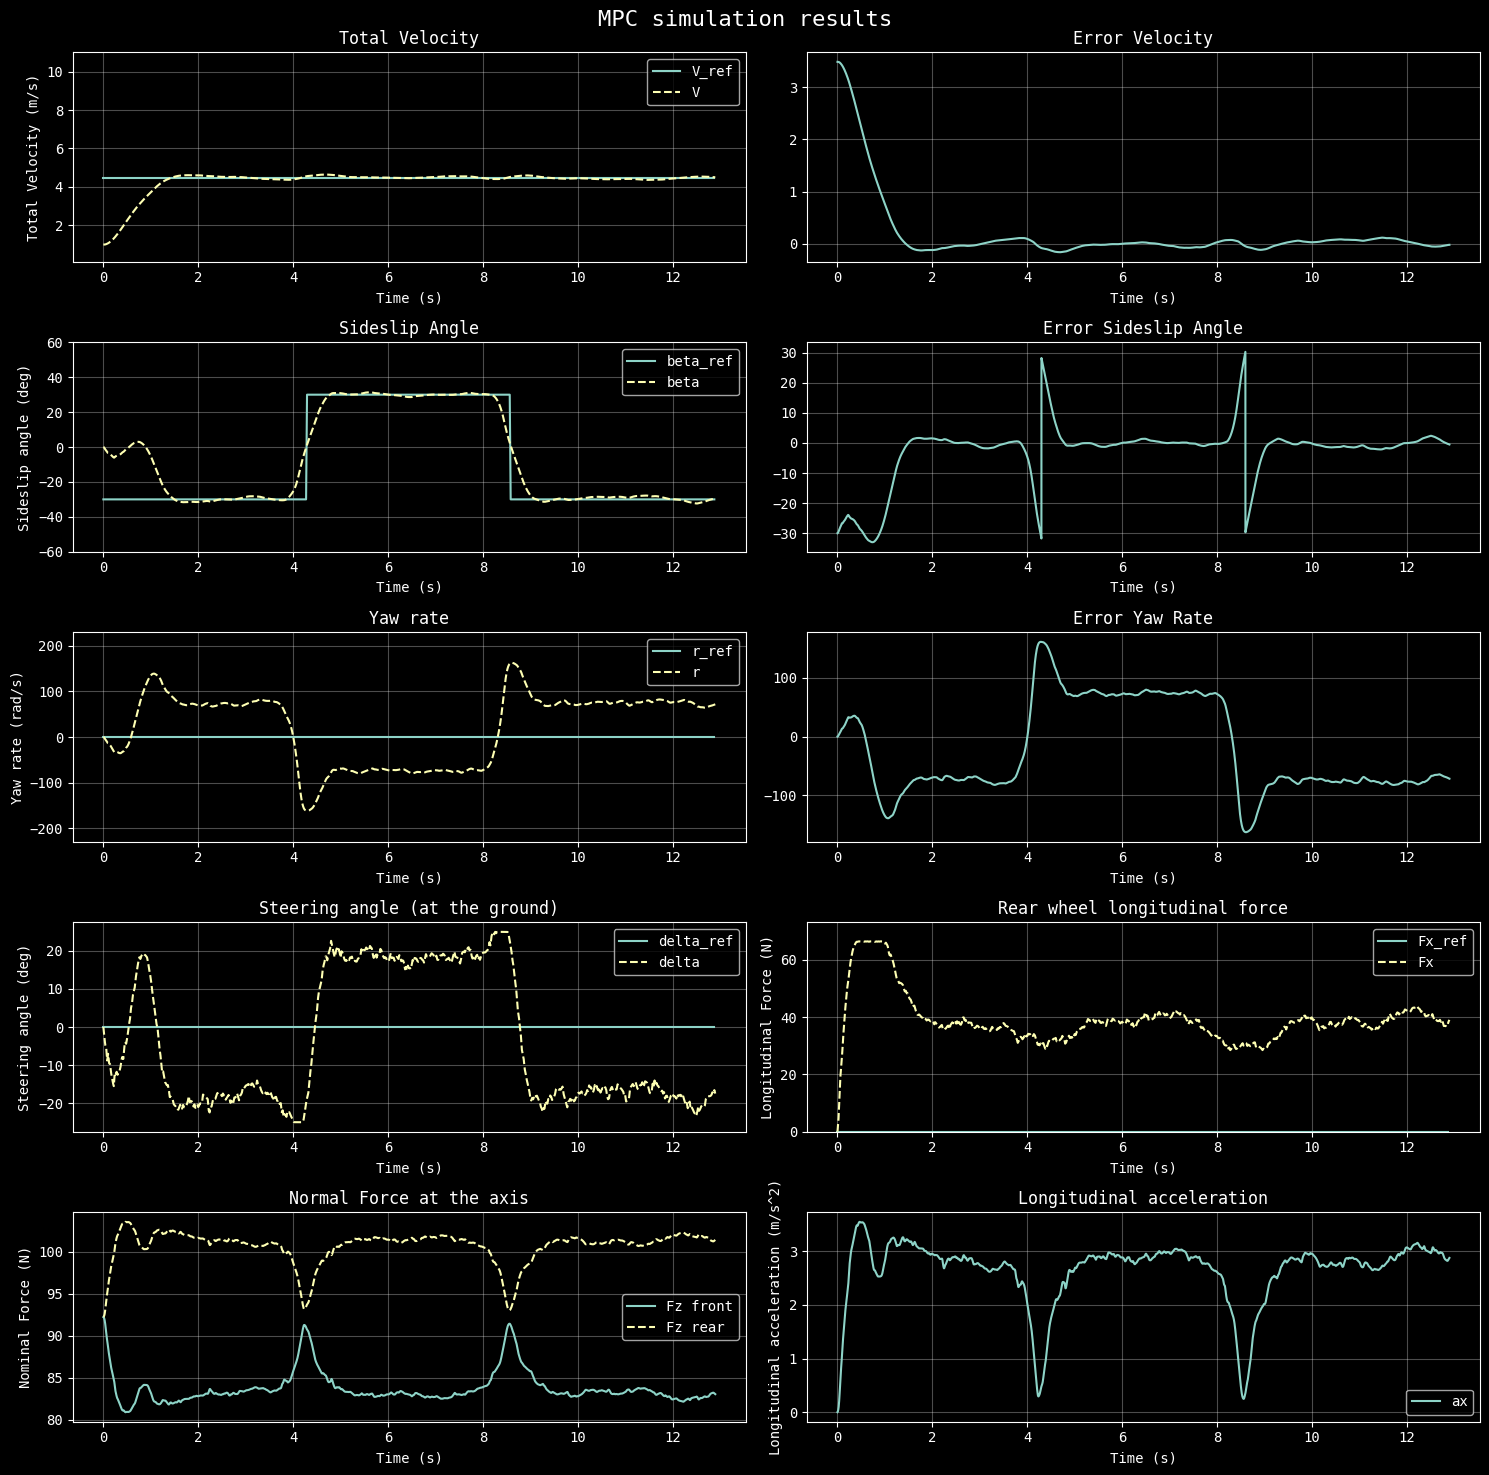

In [9]:
time        = np.linspace(0, ts_sim * N_steps, N_steps + 1)
time_mpc    = np.linspace(0, Ts * (N_steps_dt-1), N_steps_dt+1)

y_ref_plot = piecewise_constant(y_ref_nolookahead[:-1], [Ts]*(y_ref_nolookahead.shape[0]-1), ts_sim)[0]
errors = y_ref_plot[:,:3] - simX[:,:3]

# plot the simulation results
CM = 'jet' #'inferno'
fig = plt.figure(figsize=(15, 15))
plt.subplot(5,2,1)
plt.plot(time_mpc, y_ref_nolookahead[:, 0], label='V_ref')
plt.plot(time, simX[:, 0], linestyle='--', label='V')
plt.title('Total Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Total Velocity (m/s)')
plt.ylim(1.1*V_lb, 1.1*V_ub)
plt.legend()

plt.subplot(5,2,2)
plt.plot(time, errors[:,0], label='error')
plt.title('Error Velocity')
plt.xlabel('Time (s)')

plt.subplot(5,2,3)
plt.plot(time_mpc, np.rad2deg(y_ref_nolookahead[:, 1]), label='beta_ref')
plt.plot(time, np.rad2deg(simX[:, 1]), linestyle='--', label='beta')
plt.title('Sideslip Angle')
plt.xlabel('Time (s)')
plt.ylabel('Sideslip angle (deg)')
plt.ylim(-60, 60)
plt.legend()

plt.subplot(5,2,4)
plt.plot(time, np.rad2deg(errors[:,1]), label='error')
plt.title('Error Sideslip Angle')
plt.xlabel('Time (s)')

plt.subplot(5,2,5)
plt.plot(time_mpc, np.rad2deg(y_ref_nolookahead[:, 2]), label='r_ref')
plt.plot(time, np.rad2deg(simX[:, 2]), linestyle='--', label='r')
plt.title('Yaw rate')
plt.xlabel('Time (s)')
plt.ylabel('Yaw rate (rad/s)')
plt.ylim(np.rad2deg(-4),np.rad2deg(4))
plt.legend()

plt.subplot(5,2,6)
plt.plot(time, np.rad2deg(errors[:,2]), label='error')
plt.title('Error Yaw Rate')
plt.xlabel('Time (s)')

plt.subplot(5,2,7)
plt.plot(time_mpc, np.rad2deg(y_ref_nolookahead[:,3]), label='delta_ref')
plt.plot(time, np.rad2deg(simX[:, 3]), linestyle='--', label='delta')
plt.title('Steering angle (at the ground)')
plt.xlabel('Time (s)')
plt.ylabel('Steering angle (deg)')
plt.ylim(np.rad2deg(1.1*delta_lb), np.rad2deg(1.1*delta_ub))
plt.legend()

plt.subplot(5,2,8)
plt.plot(time_mpc, y_ref_nolookahead[:,4], label='Fx_ref')
plt.plot(time, simX[:, 4], linestyle='--', label='Fx')
plt.title('Rear wheel longitudinal force')
plt.xlabel('Time (s)')
plt.ylabel('Longitudinal Force (N)')
plt.ylim(1.1*Fx_lb, 1.1*Fx_ub)
plt.legend()

plt.subplot(5,2,9)
# plt.plot(time_mpc, y_ref_nolookahead[:,5], label='Fx_ref')
plt.plot(time, Fz_Front_ST - simX[:, 5], label='Fz front')
plt.plot(time, Fz_Rear_ST + simX[:, 5], linestyle='--', label='Fz rear')
plt.title('Normal Force at the axis')
plt.xlabel('Time (s)')
plt.ylabel('Nominal Force (N)')
# plt.ylim(1.1*Fx_lb, 1.1*Fx_ub)
plt.legend()

plt.subplot(5,2,10)
# plt.plot(time_mpc, y_ref_nolookahead[:,5], label='Fx_ref')
plt.plot(time, simX[:, 5]*l/(m*h), label='ax')
plt.title('Longitudinal acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Longitudinal acceleration (m/s^2)')
# plt.ylim(1.1*Fx_lb, 1.1*Fx_ub)
plt.legend()


plt.suptitle('MPC simulation results', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
print("Final state:")
print(f"V: {simX[-1,0]:.2f} m/s")
print(f"Beta: {np.rad2deg(simX[-1,1]):.2f} deg")
print(f"Yaw rate: {np.rad2deg(simX[-1,2]):.2f} deg/s")
print(f"Delta: {np.rad2deg(simX[-1,3]):.2f} deg")
print(f"Fx: {simX[-1,4]:.2f} N")

Final state:
V: 4.50 m/s
Beta: -29.47 deg
Yaw rate: 71.60 deg/s
Delta: -17.48 deg
Fx: 39.01 N


In [ ]:
# animation
anim = car_anim(
    xs=simX[:,:3],  # use the state vector as input
    # us=piecewise_constant(simU, [Ts]*simU.shape[0], ts_sim)[0],
    us=piecewise_constant(simX[:-1,3:5], [ts_sim]*(simX.shape[0]-1), ts_sim)[0],
    ic=np.array([0, 0, π/2]),  # initial conditions (x, y, ψ) 
    dt=ts_sim,  # time step
    fps=60,  # frames per second
    speed=1,  # speed factor for the animation 
    # follow=True,  # follow the car in the animation
    title='MPC simulation results',  # title of the animation
    # get_video=True,  # get video instead of jshtml
    # static_img=True,  # use static image instead of animation
)  # run the car animation with the STM results